# NEM DATA CHALLENGE, 2nd Phase: 
## POWER GENERATION Prediction Module

* Author: Sergio Díaz
* Date: September 2017

In [65]:
'''
Version Control

V02 ok: include 24h_scada_power into forecast10m dataframe: done but discarded.
    ok: Instead read 24h scada data directly from csv file and filter prediction 
        dataframe with 24_pwr_scada.index.: done

V03 ok: Renaming of some variables and functionns
    ok: Plotting scada vs prediction
    ok: include range in dataframes
    ok: saving prediction to CSV

V04 ok: Separate ML model training from prediction

V05 ok: Separate into two scripts, prediction and learning 

V06 pend: Detect Nan values in input files and avoid prediction. improve results for 09.09
    pend: Check plots labels
''';

In [66]:
%matplotlib notebook

In [67]:
import os
import math
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

<IPython.core.display.Javascript object>


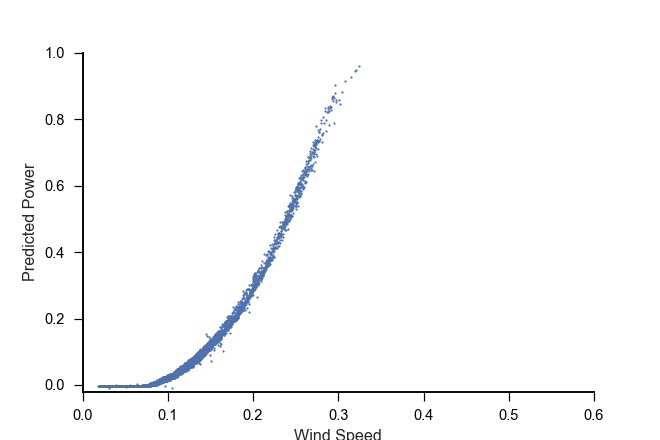

<IPython.core.display.Javascript object>


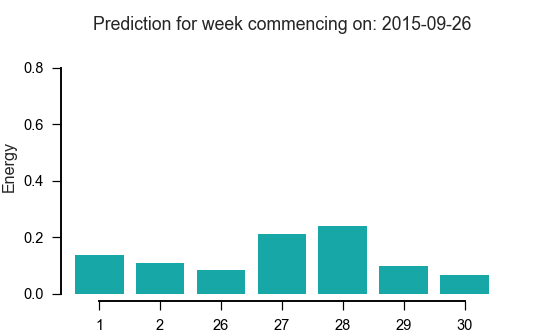

<IPython.core.display.Javascript object>


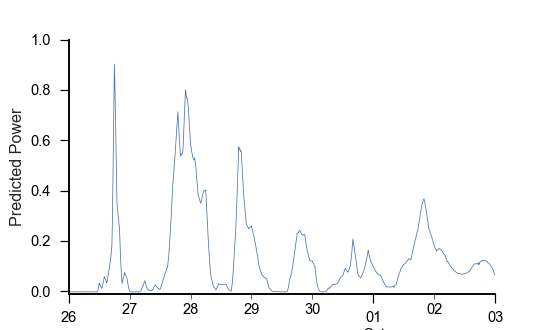

In [74]:
def main():
    ''' '''
    # SELECT evaluation date: 
    #'2015-09-01','2015-09-09','2015-09-17','2015-09-25','2015-10-03','2015-10-10'
    #
    
    options = { 'evaluation_date': '2015-09-25', # SELECT Evaluation date
                'validation_score':           0, # Show validation scores
                'pwr_curve_7d':               1, # y_pred vs y_test on 5 months SCADA (time series)  
                'pwr_curve_24h' :             0, # model error metrics wrt Validation data
                'mean_energy'   :             1, # y_pred vs y_val on 24 hr scada dates (time-series)
                'mean_pwr':                   1, # pwr_curve with sub-optimal data pairs 
                'pwr_time' :                  0, #
                'wind_forecast':              0, #
                'temp_forecast':              0, #
                'save_file':                  0, #
              }
    
    power_prediction(options)

if __name__ == "__main__":
    main()

## PREDICTION

In [73]:
def power_prediction(options):
    '''  '''
    # define i/o paths
    cwd = os.getcwd()
    # path to ML models
    model_path = os.path.join(cwd,'models')
    # path to results
    result_path = os.path.join(cwd,'predictions')
    #
    if not os.path.exists(result_path):
        os.mkdir(result_path)    

    ## INPUTS
    
    df_weather = weather_forecast(options)
    df_scada = read_evaluation_scada(options)[['WTURPower', 'asset']]
    eval_date = options['evaluation_date']
    
    # ******************************************
    # PREDICTION FOR 24SCADA AND 7d FORECAST USING ML model

    # Loop over assets
    assets = df_weather.asset.unique()
    for i, asset in enumerate(assets):

        # 8-day ENERGY PREDICTION    
        mask = df_weather.asset == asset
        x_pred = df_weather.loc[mask,['WNACWindSpeed', 'WNACAmbTemp']]
        
        # read previously trained ML odel
        in_file = 'model_'+ asset + '.sav'
        with open(model_path +  '/' + in_file, 'rb') as f:
            model = pickle.load(f) 
            
        # power prediction for 1 scada + 7 days forecast
        y_pred = model.predict(x_pred)
        
        # real target values (pwr) for 24hr
        mask = df_scada.asset==asset
        y_eval = df_scada.loc[mask, 'WTURPower']
        indx = y_eval.index       
        
        # Build dataframe with predicted values for 1+7 days
        if i == 0:
            df_prediction = pd.DataFrame(data=y_pred, index=x_pred.index, columns=['energy_production'])
            df_prediction['asset']=asset                             
        else:
            df_concat = pd.DataFrame(data=y_pred, index=x_pred.index, columns=['energy_production'])
            df_concat['asset']=asset                     
            df_prediction = pd.concat([df_prediction,df_concat], axis=0)

            
        if i == 0:
            df_pred = x_pred.copy()
            df_pred['WTURPower'] = y_eval
            df_pred['asset'] = asset
            df_pred['predicted_power'] = y_pred
        else:
            df_concat = x_pred.copy()
            df_concat['WTURPower'] = y_eval
            df_concat['asset'] = asset
            df_concat['predicted_power'] = y_pred          
            df_pred = pd.concat([df_pred, df_concat], axis=0)            
            
            
        # *************************************************************
        # ML_MODEL SCORE comparing predicted power with 24h scada power

        # scada slice per asset
        #mask = df_scada.asset==asset
        #y_eval_pwr = df_scada.loc[mask, 'WTURPower']
        #indx = y_eval_pwr.index

        # slice predicte values using 24hs_cada_index (needed in case of gaps in scada)
        y_pred_pwr = df_prediction.loc[indx] 
        y_pred_pwr = y_pred_pwr.loc[ (y_pred_pwr.asset==asset),'energy_production' ] 

        # metrics
        mse = mean_squared_error(y_eval, y_pred_pwr)*100
        mae = mean_absolute_error(y_eval, y_pred_pwr)*100
        r2  = r2_score(y_eval, y_pred_pwr)*100

        # Results output    
        if options['validation_score']==1:
            if i==0: 
                print('ML model score for Evaluation date: {}'.format(eval_date)) 
            print('Asset: {}'.format(asset) )
            print("100x Mean squared error: {:.5f}".format(mse))
            print("100x r2_score: {:.5f}".format(r2))
            print("100x Mean absolute error: {:.5f}".format(mae))    
            print("")
        
        
        # PLOT POWER CURVES 24HRS SCADA
        if options['pwr_curve_24h'] ==1:
            
            df_A = df_pred [df_pred.asset==asset]
            start_date = pd.to_datetime(eval_date) + pd.DateOffset(days=1)
            date_mask = df_A.index < start_date            
            df_B = df_A.loc[date_mask]
            fig, (ax1) = plt.subplots(1,1, figsize=(6,4) )
            df_A.plot.scatter('WNACWindSpeed', 'WTURPower', ax=ax1, marker='*', s=20, c='b', label = '24Hr SCADA')
            df_B.plot.scatter('WNACWindSpeed', 'predicted_power', ax=ax1, marker='.', s=20, c='r', label='predicted')
            ax1.set_title('Date: ' + eval_date + '  asset: ' + asset)
            ax1.set_ylabel('Predicted WTURPower')    
        
        
        # PLOT POWER CURVES 7-DAY 
        
        if options['pwr_curve_7d']==1:   
            df_A = df_pred [df_pred.asset==asset]
            start_date = pd.to_datetime(eval_date) + pd.DateOffset(days=1)
            date_mask = df_A.index >= start_date            
            df_A = df_A.loc[date_mask]
            if i==0: fig, ax1 = plt.subplots( figsize=(6,4))
            df_A.plot.scatter('WNACWindSpeed', 'predicted_power', ax=ax1, marker='.', s=5)
            #ax1.set_title('Date: ' + evaluation_date + '  asset: ' + asset)
            ax1.set_xlim([0, .6])
            ax1.set_ylim([-.02,  1])
            ax1.set_ylabel('Predicted Power')
            ax1.set_xlabel('Wind Speed')       
        
    # remove 24h_scada data from df_prediction dataframe
    start_date = pd.to_datetime(eval_date) + pd.DateOffset(days=1)
    date_mask = df_prediction.index >= start_date
    df_output = df_prediction[date_mask] 
    
    # plot daily MEAN ENERGY OUTPUT  for 7-day period
    if options['mean_energy']==1:   
        
        df_mean_pwr = df_output.groupby(df_output.index).mean()
        df_daily_pwr = df_mean_pwr.resample('D').sum()[:-1]/144
        
        fig, ax = plt.subplots(figsize=(5, 3))
        y = df_daily_pwr['energy_production'] 
        x = df_daily_pwr.index.day
        sns.set_style('white')
        sns.set_context('paper', font_scale=1.2)
        sns.set_style('ticks', {'axes.edgecolor': '0', 'xtick.color': '0', 'ytick.color': '0'})
        sns.barplot(x=x, y=y, data=df_daily_pwr, color='c')
        ax.set_title('Prediction for week commencing on: '+ str(start_date.date()))
        ax.set_xlabel('day')
        ax.set_ylabel('Energy')
        ax.set_ylim([0, 0.9])
        sns.despine(offset=5, trim=True)
        plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
        plt.setp(ax.lines, color='k')
        #sfig('DayPower')    
    

    # plot predicted MEAN POWER for 7-day period

    if options['mean_pwr']==1:   
        df_mean_pwr = df_output.groupby(df_output.index).mean()      
        fig, ax1 = plt.subplots(figsize=(5, 3))
        df_mean_pwr.plot(ax=ax1, lw=.5, legend=None)
        #ax1.set_title('Prediction for week commencing on: '+ str(start_date.date()))
        ax1.set_ylabel('Predicted Power')       
        ax1.set_ylim([-.01, 1])   
    
    
    # *********************************************************************************
    # SAVE to CSV FILE ???
    if options['save_file'] == 1:
        
        # transform datetime index to range and rename column
        df_output.index = df_output.index.astype(np.int64) // 10**9
        df_output.index = df_output.index - df_output.index[0]
        df_output.index.name = 'range'
        df_output.reset_index(inplace=True)

        out_file = 'Prediction_'+ eval_date + '.csv'
        df_output.to_csv(result_path +  '/' + out_file, index=False)
        print('CSV file saved')    


    # **************************************************************************
    # PLOTS
    if options['pwr_time']==1:
        mystyle()
        plotvar = 'energy_production'
        for asset in assets:    
            fig, ax1 = plt.subplots( figsize=(10,3.4) )
            mask = df_prediction.asset==asset
            df_prediction.loc[mask,plotvar].plot(ax=ax1, lw=0, marker = '.', color='g', legend='Predicted')
            mask = df_scada.asset==asset
            df_scada.loc[mask,'WTURPower'].plot(ax=ax1, lw=.3, color='b', legend='24hr SCADA')

            ax1.set_title('Power output for asset: '+ asset)
            ax1.set_ylabel('WTURPower')
            mylabels= ['Predicted' , '24Hr SCADA']
            ax1.legend(labels = mylabels)
            plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0 );

### WEATHER FORECAST

In [70]:
def weather_forecast(options):
    ''' 
    # ******************************************************************************************
    # GENERATE 7-Days WEATHER FORECAST TO BE USED AS INPUT FOR WIND POWER GENERATION PREDICTION
    # ******************************************************************************************
    '''
    
    # ************************************************    
    # READ EVALUATION WEATHER and SCADA DATASETS 

    # Evaluation Weather Forecast
    df_forecast = read_evaluation_forecast(options)
    assets = df_forecast.asset.unique()
    uxtimes = df_forecast.unixtime.unique()[0]
    datetimes = df_forecast.datetime.unique()[0]
    df_forecast.set_index(['asset','rangedt'], inplace=True)

    # Evaluation Scada Data
    df_scada = read_evaluation_scada(options)
    scada_weather = df_scada[['WNACWindSpeed', 'WNACAmbTemp', 'asset']]
    scada_weather.set_index('asset', append=True, inplace=True)
    scada_weather = scada_weather.reorder_levels(['asset','datetime'])
    scada_weather.sort_index(inplace=True)

    #     
    # ************************************************    
    # CREATE an EMPTY 7 Days HOURLY dataframe for PREDICTION

    start = 3600
    stop = 7*24*3600 + 3600
    step = 3600
    rang = np.arange(start, stop , step) # seconds in 7 days at HOURLY steps
    df = pd.DataFrame(data=rang, columns=['range'])

    for i, asset in enumerate (assets):
        df['asset']=asset
        df['unixtime']=uxtimes 
        if i==0:
            df_time = df.copy()
        else:    
            df_time = pd.concat([df_time, df], axis=0)
    df_time['rangedt'] = pd.to_datetime(df_time['unixtime'] + df_time['range'], unit='s') 
    df_time['datetime'] = pd.to_datetime(df_time['unixtime'], unit='s')
    df_time['WNACWindSpeed']=np.nan
    df_time['WNACAmbTemp']=np.nan
    df_time.set_index(['asset','rangedt'], inplace=True)
    forecast60m = df_time.copy()

    
    # *********************************************************************
    # POPULATE 7-day PREDICTION dataframe with  Evaluation WEATHER Forecast

    # Copy values from Evaluation forecast to Prediction FORECAST
    indx = df_forecast.index
    forecast60m.loc[indx, 'WNACWindSpeed'] = df_forecast.WNACWindSpeed
    forecast60m.loc[indx, 'WNACAmbTemp'] = df_forecast.WNACAmbTemp

    # ****************************************************
    # Calculate Mean Values across assets to fill_gaps

    forecast60m.reset_index(level='asset', inplace=True)   
    df_mean = forecast60m.groupby(['datetime', forecast60m.index]).mean()
    df_mean.reset_index(level=['datetime'], inplace=True)

    # Fill-in missing values with calculated mean values 
    for asset in assets:
            mask= (forecast60m.asset==asset)
            forecast60m[mask] = forecast60m[mask].combine_first(df_mean) 

    forecast60m.set_index('asset', append=True, inplace=True)
    forecast60m = forecast60m.reorder_levels(['asset','rangedt'])
    
    # *********************************************************************    
    # CREATE an EMPTY 10minutal PREDICTION DATAFRAME from Sept-01 to Oct-18

    periods = (7+1)*24*6+1  # 8 (days)* 24 (hrs/day) * 6 (10min/hr)
    eval_date = options['evaluation_date']
    rangedt = pd.date_range(eval_date, periods=periods, freq='10Min')
    df = pd.DataFrame(data=rangedt, columns=['rangedt'])
    for i, asset in enumerate (assets):
        df['asset']=asset  
        if i==0:
            df_time = df.copy()
        else:    
            df_time = pd.concat([df_time, df], axis=0)

    df_time['WNACWindSpeed']=np.nan
    df_time['WNACAmbTemp']=np.nan
    df_time.set_index(['asset','rangedt'], inplace=True)
    forecast10m = df_time.copy()

    # **********************************************************    
    # POPULATE 10minutal PREDICTION DATAFRAME

    # Copy values from hourly prediction dataframe
    indx = forecast60m.index
    forecast10m.loc[indx, 'WNACWindSpeed'] = forecast60m.WNACWindSpeed
    forecast10m.loc[indx, 'WNACAmbTemp'] = forecast60m.WNACAmbTemp

    # Copy values from SCADA to 10m prediction forecast
    indx = scada_weather.index
    forecast10m.loc[indx, 'WNACWindSpeed'] = scada_weather.WNACWindSpeed
    forecast10m.loc[indx, 'WNACAmbTemp'] = scada_weather.WNACAmbTemp

    # FILL-IN 10Min intervals by interpolating Hourly Forecast
    forecast10m.interpolate( inplace=True)
    
    # FLATTEN DATAFRAME INDEX
    forecast10m.reset_index(level='asset', inplace=True)
    
    # **************************************************************************
    # PLOTS
    
    if options['wind_forecast']==1:
        mystyle()
        plotvar = 'WNACWindSpeed'
        #plotvar = 'WNACAmbTemp'
        fig, ax1 = plt.subplots( figsize=(10,4) )
        for asset in assets:    
            
            mask = forecast10m.asset==asset
            dfplot = forecast10m.loc[mask,plotvar] 
            dfplot.plot(ax=ax1, lw=0.8, legend=asset)
        title = 'Wind Speed forecast for week commencing on : '
        ax1.set_title( title + eval_date)
        ax1.set_ylabel(plotvar)
        ax1.set_xlabel('month-day')
        plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0 )
        mylabels= ['A01' , 'A02', 'A03', 'A04', 'A05']
        ax1.legend(labels = mylabels)
            
            
    if options['temp_forecast']==1:
        mystyle()
        plotvar = 'WNACAmbTemp'
        fig, ax1 = plt.subplots( figsize=(10,4) )
        for asset in assets:        
            mask = forecast10m.asset==asset
            dfplot = forecast10m.loc[mask,plotvar] 
            dfplot.plot(ax=ax1, lw=0.8, legend=asset)
        title = 'Wind Speed forecast for week commencing on : '
        ax1.set_title( title + eval_date)
        ax1.set_ylabel(plotvar)
        ax1.set_xlabel('month-day')
        plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0 ); 
        mylabels= ['A01' , 'A02', 'A03', 'A04', 'A05']
        ax1.legend(labels = mylabels)
            
    return forecast10m

## READ CSV FILES

In [71]:
def read_evaluation_scada(options):
    ''' '''
    cwd = os.getcwd()    
    # path to 24hr scada
    in_path = os.path.join(cwd,'datasets', 'evaluation', 'online')
    in_file = options['evaluation_date'] +'.csv'         
    in_csv  = os.path.join(in_path,in_file)          
    df = pd.read_csv(in_csv)
    df['datetime'] = pd.to_datetime(df['unixtime'], unit='s')
    df.set_index('datetime', inplace=True)
    # Data cleaning
    df = df.dropna(axis=0) 
    # Remove near-zero Power values at windspeed higher than 0.1
    mask = np.invert((df.WTURPower < 0.001) & (df.WNACWindSpeed > 0.10)) 
    #df = df[mask]
    
    return df 

def read_evaluation_forecast(options):
    ''' '''
    cwd = os.getcwd()
    in_path = os.path.join(cwd,'datasets', 'evaluation', 'forecasts')
    eval_date = pd.to_datetime(options['evaluation_date']) + pd.DateOffset(days=1)
    dates = str(eval_date.date())
    in_file = dates +'.csv'         
    in_csv  = os.path.join(in_path,in_file)          
    df = pd.read_csv(in_csv)
    df['rangedt'] = pd.to_datetime(df['unixtime']+df['range'], unit='s')        
    df['datetime'] = pd.to_datetime(df['unixtime'], unit='s')        
    return df     

## PLOT STYLE

In [72]:
def mystyle():
    plt.style.use('seaborn-white')
    plt.rcParams ['axes.grid']=False 
    plt.rcParams ['axes.spines.left']   = True   # display axis spines
    plt.rcParams ['axes.spines.bottom'] = True
    plt.rcParams ['axes.spines.top']    = False
    plt.rcParams ['axes.spines.right']  = False 